This is a Convolutional GAN with "moment stabilization" based off of the "Intro to GANs" Lesson from the Udacity Deep Learning Foundations Nanodegree: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb. 

In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def model_inputs(image_width, image_height, image_channels, z_dim):

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    Z = tf.placeholder(tf.float32, [None, z_dim])
    
    return real_input, Z

In [4]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    reuse_ = not is_train
    with tf.variable_scope('generator', reuse=reuse_):
        # TODO: Implement Function
        h0 = tf.layers.dense(z, 1024, kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        h0 = tf.layers.batch_normalization(h0, training=is_train)
        h0 = tf.maximum(alpha * h0, h0)
        h1 = tf.layers.dense(h0, 7*7*256, kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        h1 = tf.reshape(h1, (-1, 7, 7 ,256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        h2 = tf.layers.conv2d_transpose(h1, 32, 3, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, 3, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        out = tf.tanh(logits)
        return out, logits

In [5]:
def discriminator(images, reuse=False, alpha=0.2):
    h_dim = 28
    w_dim = 28
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 32, 3, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 256, 3, strides=2, padding='SAME' , kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        
        flat = tf.reshape(h2, (-1, 7*7*256))
        flat = tf.nn.dropout(flat, 0.5)
        logits = tf.layers.dense(flat, 1 , kernel_initializer=tf.contrib.layers.xavier_initializer(), bias_initializer=tf.constant_initializer(0.1))
        out = tf.sigmoid(logits)

        return out, logits

<h2>Hyperparameters</h2>

In [6]:
input_size = 784
z_dim = 100
smooth = 0.1
out_channel_dim = 1
h_dim = 28
w_dim = 28
batch_size = 100
epochs = 20

<h2>Moments</h2>
We multiply the moments by 0.1 to keep them roughly in line with the original generator loss.

In [7]:
tf.reset_default_graph()
input_real, input_z = model_inputs(w_dim, h_dim, out_channel_dim, z_dim)

g_model, g_logits = generator(input_z, out_channel_dim)
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

In [8]:
g_mean, g_var = tf.nn.moments(g_model, axes=[0])
d_mean, d_var = tf.nn.moments(input_real, axes=[0])

mean_diff = 0.1 * tf.reduce_sum(tf.abs(g_mean - d_mean))
var_diff = 0.1 * tf.reduce_sum(tf.abs(g_var - d_var))


<h2>Modified Loss Function</h2>

In [9]:
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))) 
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))) + (var_diff + mean_diff)

d_loss = d_loss_real + d_loss_fake

In [10]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if var.name.startswith('discrim')]
g_vars = [var for var in t_vars if var.name.startswith('gener')]
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
    g_train_opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(g_loss, var_list=g_vars)

d_train_opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(d_loss, var_list=d_vars)

In [11]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [12]:
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 28, 28, 1))
            batch_images = (batch_images/1. - 0.5) * 2
            
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))          
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
        
        train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g)) 
        var_diff1 = var_diff.eval(session=sess, feed_dict={input_real: batch_images, input_z: batch_z})
        mean_diff1 = mean_diff.eval(session=sess, feed_dict={input_real: batch_images, input_z: batch_z})
        print('Var_diff: ' +str(var_diff1) + ' Mean_diff: ' +str(mean_diff1))
        losses.append((train_loss_d, train_loss_g))
        sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
        gen_samples, _ = sess.run(
                       generator(input_z, out_channel_dim, is_train=False),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/20... Discriminator Loss: 0.7282... Generator Loss: 19.7816
Var_diff: 7.52033 Mean_diff: 8.83881
Epoch 2/20... Discriminator Loss: 0.6274... Generator Loss: 9.0371
Var_diff: 3.18306 Mean_diff: 3.50239
Epoch 3/20... Discriminator Loss: 0.6442... Generator Loss: 8.4750
Var_diff: 2.76697 Mean_diff: 2.93169
Epoch 4/20... Discriminator Loss: 0.9927... Generator Loss: 8.3074
Var_diff: 3.07821 Mean_diff: 3.20741
Epoch 5/20... Discriminator Loss: 0.8338... Generator Loss: 7.6685
Var_diff: 2.72721 Mean_diff: 3.09408
Epoch 6/20... Discriminator Loss: 1.2176... Generator Loss: 7.7823
Var_diff: 2.56504 Mean_diff: 2.93122
Epoch 7/20... Discriminator Loss: 1.1337... Generator Loss: 7.6586
Var_diff: 3.12671 Mean_diff: 3.18258
Epoch 8/20... Discriminator Loss: 1.2188... Generator Loss: 8.5164
Var_diff: 3.17345 Mean_diff: 3.4168
Epoch 9/20... Discriminator Loss: 0.9896... Generator Loss: 8.2904
Var_diff: 3.45124 Mean_diff: 3.44696
Epoch 10/20... Discriminator Loss: 1.5195... Generator Loss: 7.4

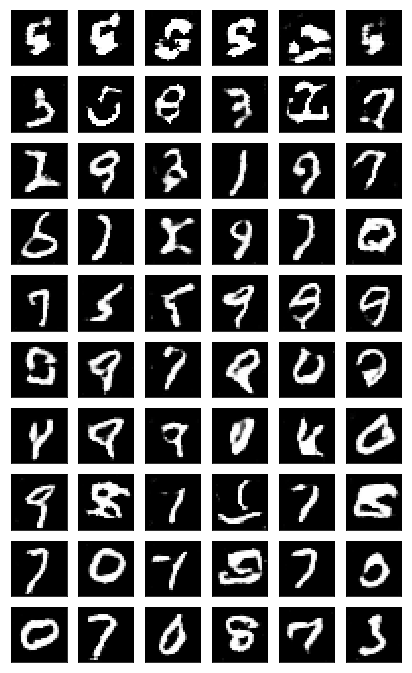

In [13]:
rows, cols = 10, 6 
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)